# 1️⃣ Import Necessary Dependencies.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import string
import random
import nltk
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer ,word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import time

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
sns.set()


# 2️⃣ Read and Load the Dataset.

In [2]:
df=pd.read_csv("training.1600000.processed.noemoticon.csv",encoding="ISO-8859-1",names=["target", "ids", "date", "flag", "user", "text"])

In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.drop(['ids','date','flag','user'],axis=1,inplace=True)

In [5]:
df.duplicated().sum()

16309

In [6]:
df.drop_duplicates(inplace=True)

df.shape

(1583691, 2)

In [7]:
df['target']=df['target'].map({0:'Negative',4:'Positive'})

In [8]:
df.sample(10)

,target,text
1067416,Positive,3 cans and basic instinct.. not that bad. i ca...
406595,Negative,@HeartSong01 Me too. I'm stuck here for anothe...
1470805,Positive,Just spoke at the US Navy 2009 Public Affairs ...
1513167,Positive,la work. coffe and shits. de maine incepem al ...
1392163,Positive,@ElizaEnraged the people we wanted to be like ...
1256868,Positive,@centernetworks Oh you over that side now ey? ...
371252,Negative,Are girls with careers even cool anymore? Why ...
186906,Negative,@TreverKeith Hi! This is your annoying-ass sta...
1069876,Positive,@selenagomez @ddlovato you 2 are soooooooooooo...
464046,Negative,"@pearlofthesea_ I FUCKEN LOVE TRUE BLOOD, but ..."


In [9]:
df['target'].value_counts()

target
Positive    793506
Negative    790185
Name: count, dtype: int64

# 3️⃣ Exploratory Data Analysis.

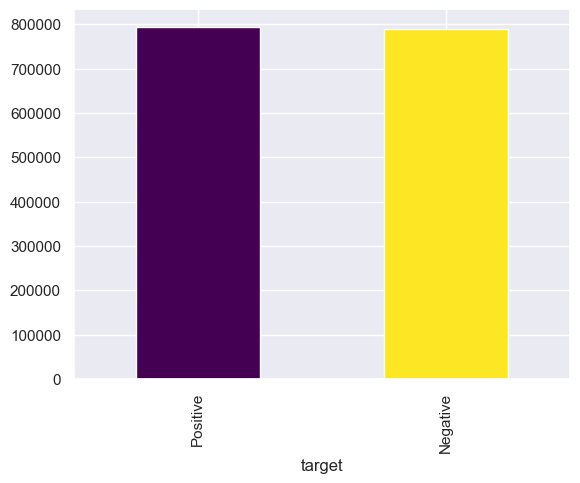

In [10]:
sentiment_content=df['target'].value_counts()
color=plt.get_cmap('viridis')
colors = [color(i) for i in np.linspace(0, 1, len(sentiment_content))]
sentiment_content.plot(kind='bar',color=colors)
plt.show()

In [11]:
df=df[df['text'].apply(len)>5]

In [12]:
def _get_wordcounts(x):
    length = len(str(x).split())
    return length

def _get_charcounts(x):
    s = x.split()
    x = ''.join(s)
    return len(x)

def _get_avg_wordlength(x):
    count = _get_charcounts(x)/_get_wordcounts(x)
    return count

def _get_stopwords_counts(x):
    l = len([t for t in x.split() if t in stopwords])
    return l

def _get_hashtag_counts(x):
    l = len([t for t in x.split() if t.startswith('#')])
    return l

def _get_mentions_counts(x):
    l = len([t for t in x.split() if t.startswith('@')])
    return l

def _get_digit_counts(x):
    digits = re.findall(r'[0-9,.]+', x)
    return len(digits)

def _get_uppercase_counts(x):
    return len([t for t in x.split() if t.isupper()])

In [13]:
df['char_counts'] = df['text'].apply(lambda x: _get_charcounts(x))
df['word_counts'] = df['text'].apply(lambda x: _get_wordcounts(x))
df['avg_wordlength'] = df['text'].apply(lambda x: _get_avg_wordlength(x))
df['stopwords_counts'] = df['text'].apply(lambda x: _get_stopwords_counts(x))
df['hashtag_counts'] = df['text'].apply(lambda x: _get_hashtag_counts(x))
df['mentions_counts'] = df['text'].apply(lambda x: _get_mentions_counts(x))
df['digits_counts'] = df['text'].apply(lambda x: _get_digit_counts(x))
df['uppercase_counts'] = df['text'].apply(lambda x: _get_uppercase_counts(x))

In [14]:
df.head()

,target,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",96,19,5.052632,4,0,1,6,1
1,Negative,is upset that he can't update his Facebook by ...,90,21,4.285714,9,0,0,2,0
2,Negative,@Kenichan I dived many times for the ball. Man...,71,18,3.944444,7,0,1,2,1
3,Negative,my whole body feels itchy and like its on fire,37,10,3.700000,5,0,0,0,0
4,Negative,"@nationwideclass no, it's not behaving at all....",90,21,4.285714,10,0,1,4,1


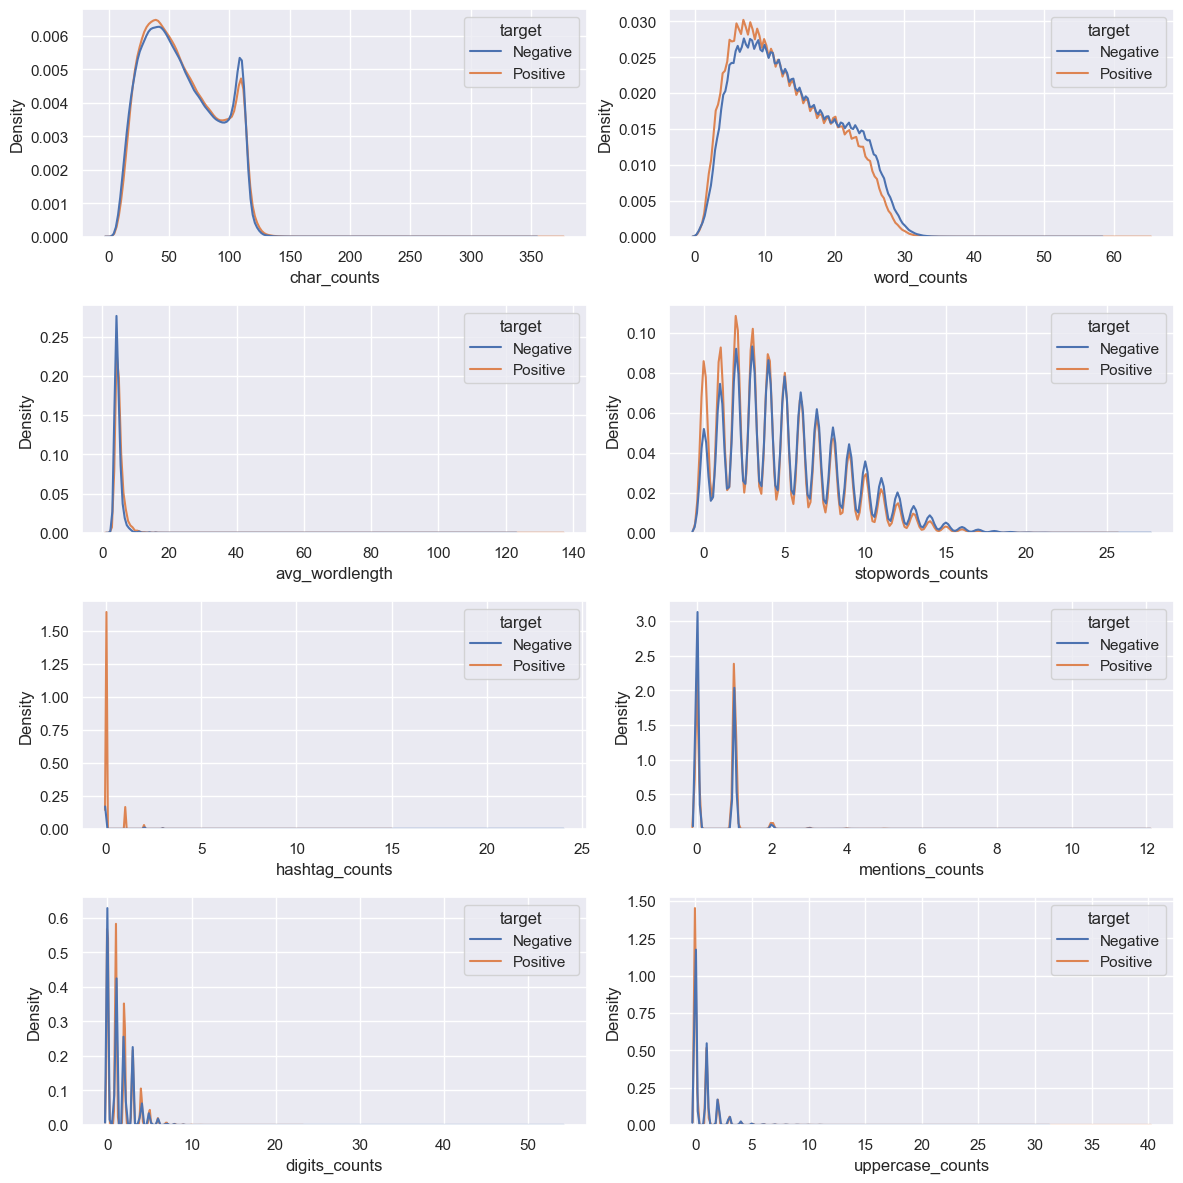

In [15]:
plt.figure(figsize=(12,12))
num_cols=df.select_dtypes(include='number').columns
for index,col in enumerate(num_cols):
    plt.subplot(4,2,index+1)
    sns.kdeplot(data=df,x=col,hue='target')
plt.tight_layout()
plt.show()

In [16]:
stopwords_list = list(stopwords)
stopwords_list.append('quot')
stopwords_list.append('ti')
stopwords_list.append('ame')
stopwords_list.append('amp')

In [17]:
print(f'There are {len(stopwords_list) } stop words')
print('**' * 20 , '\n20 of them are as follows:\n')
for inx , value in enumerate(stopwords_list[:20]):
    print(f'{inx+1}:{value}')

There are 330 stop words
**************************************** 
20 of them are as follows:

1:further
2:always
3:whom
4:thru
5:am
6:yet
7:sixty
8:without
9:your
10:everywhere
11:well
12:however
13:across
14:most
15:mine
16:though
17:as
18:side
19:thereby
20:whence


# 4️⃣ Data Preprocessing.

In [18]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', tx)



def text_cleaner(tx):   
    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , ' ' , text)
    text = re.sub(r'[?]+' , ' ' , text)
    text = re.sub(r'[.]+' , ' ' , text)
    text = re.sub(r'[@]+' , ' ' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text

def convert_to_lowercase(c):

    return c.lower()

Stemmer = PorterStemmer()

def stemming(text):
    
    words = nltk.word_tokenize(text)
    
    stemmed_words = [Stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text

lemmatizer = WordNetLemmatizer()

def lemmatization(text):

    words = nltk.word_tokenize(text)
    
    lemmatized_words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

def remove_stopwords(text):

    words = nltk.word_tokenize(text)
    
    filtered_words = [word for word in words if word.lower() not in stopwords_list]

    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text

In [19]:
df['preprocessed']=df['text'].apply(convert_to_lowercase)
df['preprocessed']=df['preprocessed'].apply(clean_emoji)
df['preprocessed']=df['preprocessed'].apply(text_cleaner)
df['preprocessed']=df['preprocessed'].apply(lemmatization)
df['preprocessed']=df['preprocessed'].apply(remove_stopwords)

df[['text','preprocessed']].head()

,text,preprocessed
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda david carr day d
1,is upset that he can't update his Facebook by ...,upset update facebook texting cry result schoo...
2,@Kenichan I dived many times for the ball. Man...,kenichan dive ames ball manage save 50 rest bound
3,my whole body feels itchy and like its on fire,body feel itchy like fire
4,"@nationwideclass no, it's not behaving at all....",nationwideclass behave mad


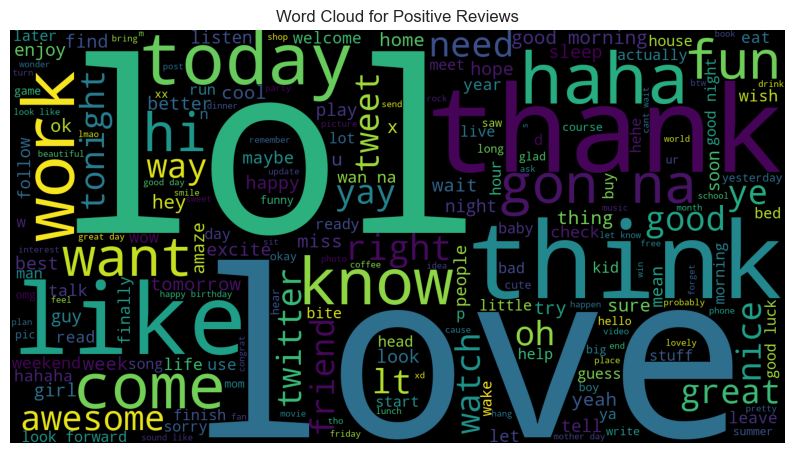

In [20]:
positive_reviews = df[df['target'] == 'Positive']['preprocessed']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

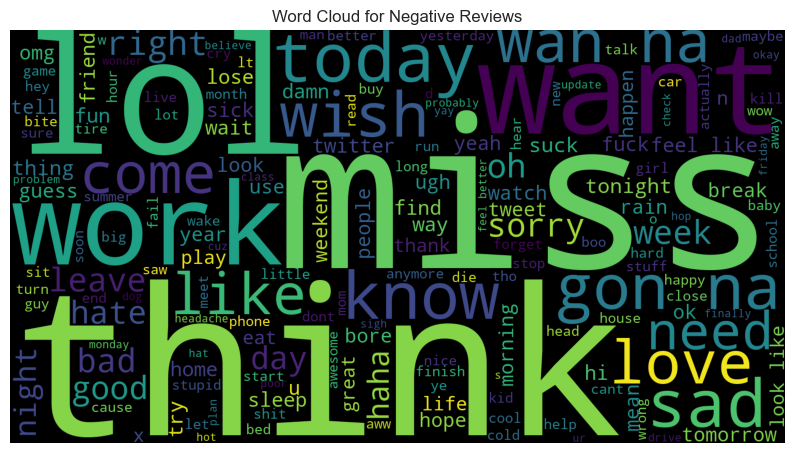

In [21]:
negative_reviews = df[df['target'] == 'Negative']['preprocessed']
neg = ' '.join(map(str, negative_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(neg)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

In [22]:
df['target']=df['target'].map({'Negative':0,'Positive':1})

# 5️⃣ Splitting our data into Train and Test Subset.

In [23]:
sample_df=df.sample(10000,random_state=60)

In [24]:
sample_df.shape

(10000, 11)

In [25]:
Xs=sample_df['text']
ys=sample_df['target']

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size = 0.2,random_state=9,stratify=ys)

print(Xs_train.shape)
print(Xs_test.shape)

(8000,)
(2000,)


# 6️⃣ Transforming Dataset using TF-IDF Vectorizer And Creating Pipelines

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X,Y=None):
        return self
    
    def transform(self, X):
        
        X_transformed = X.apply(convert_to_lowercase)
        X_transformed = X_transformed.apply(clean_emoji)
        X_transformed = X_transformed.apply(text_cleaner)
        X_transformed = X_transformed.apply(lemmatization)
#         X_transformed = X_transformed.apply(remove_stopwords)

        return X_transformed

In [27]:
LogisticRegression_pipeline = Pipeline([
    ('preprocess', Preprocessing()),
    ('Vectorization',TfidfVectorizer()),
    ('LogisticRegression',LogisticRegression())
]) 

In [28]:
RandomForestClassifier_pipeline = Pipeline([
    ('preprocess', Preprocessing()),
    ('Vectorization',TfidfVectorizer()),
    ('RandomForest',RandomForestClassifier())
])

In [29]:
NaiveBayes_pipeline = Pipeline([
    ('preprocess', Preprocessing()),
    ('Vectorization',TfidfVectorizer()),
    ('MultinomialNB',MultinomialNB())
])

In [30]:
KNeighborsClassifier_pipeline = Pipeline([
    ('preprocess', Preprocessing()),
    ('Vectorization',TfidfVectorizer()),
    ('KNeighborsClassifier',KNeighborsClassifier())
])

# 7️⃣ Training and Comparing Different Models

## LogisticRegression

In [31]:
LogisticRegression_pipeline.fit(Xs_train,ys_train)

Pipeline(steps=[('preprocess', Preprocessing()),
                ('Vectorization', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression())])

In [32]:
ys_pred = LogisticRegression_pipeline.predict(Xs_test)
ys_pred_proba = LogisticRegression_pipeline.predict_proba(Xs_test)[:, 1]

accuracy = accuracy_score(ys_test, ys_pred)
roc_auc = roc_auc_score(ys_test, ys_pred_proba)  
f1 = f1_score(ys_test, ys_pred)  

print("LogisticRegression")
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")


LogisticRegression
Accuracy: 0.7525
ROC-AUC: 0.828560314241257
F1 Score: 0.7567567567567568


## Random Forest Classifier

In [33]:
RandomForestClassifier_pipeline.fit(Xs_train,ys_train)

Pipeline(steps=[('preprocess', Preprocessing()),
                ('Vectorization', TfidfVectorizer()),
                ('RandomForest', RandomForestClassifier())])

In [34]:
ys_pred = RandomForestClassifier_pipeline.predict(Xs_test)
ys_pred_proba = RandomForestClassifier_pipeline.predict_proba(Xs_test)[:, 1]

accuracy = accuracy_score(ys_test, ys_pred)
roc_auc = roc_auc_score(ys_test, ys_pred_proba)  
f1 = f1_score(ys_test, ys_pred)  

print("RandomForestClassifier")
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")


RandomForestClassifier
Accuracy: 0.746
ROC-AUC: 0.8095562382249528
F1 Score: 0.7457457457457458


## NaiveBayes

In [35]:
NaiveBayes_pipeline.fit(Xs_train,ys_train)

Pipeline(steps=[('preprocess', Preprocessing()),
                ('Vectorization', TfidfVectorizer()),
                ('MultinomialNB', MultinomialNB())])

In [36]:
ys_pred = NaiveBayes_pipeline.predict(Xs_test)
ys_pred_proba = NaiveBayes_pipeline.predict_proba(Xs_test)[:, 1]

accuracy = accuracy_score(ys_test, ys_pred)
roc_auc = roc_auc_score(ys_test, ys_pred_proba)  
f1 = f1_score(ys_test, ys_pred)  

print("NaiveBayes")
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")


NaiveBayes
Accuracy: 0.745
ROC-AUC: 0.8214622858491435
F1 Score: 0.7269807280513919


## KNeighbors Classifier

In [37]:
KNeighborsClassifier_pipeline.fit(Xs_train,ys_train)

Pipeline(steps=[('preprocess', Preprocessing()),
                ('Vectorization', TfidfVectorizer()),
                ('KNeighborsClassifier', KNeighborsClassifier())])

In [38]:
ys_pred = KNeighborsClassifier_pipeline.predict(Xs_test)
ys_pred_proba = KNeighborsClassifier_pipeline.predict_proba(Xs_test)[:, 1]

accuracy = accuracy_score(ys_test, ys_pred)
roc_auc = roc_auc_score(ys_test, ys_pred_proba)  
f1 = f1_score(ys_test, ys_pred)  

print("KNeighborsClassifier")
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")

KNeighborsClassifier
Accuracy: 0.6605
ROC-AUC: 0.715122860491442
F1 Score: 0.6378666666666667


# 8️⃣ Training Final Model


In [39]:
X=df['text']
y=df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=9,stratify=y)

print(X_train.shape)
print(X_test.shape)

(1266952,)
(316739,)


In [40]:
LogisticRegression_pipeline = Pipeline([
    ('preprocess', Preprocessing()),
    ('Vectorization',TfidfVectorizer()),
    ('LogisticRegression',LogisticRegression())
])

In [41]:
LogisticRegression_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess', Preprocessing()),
                ('Vectorization', TfidfVectorizer()),
                ('LogisticRegression', LogisticRegression())])

# 9️⃣ Model Evalution

In [42]:
y_pred = LogisticRegression_pipeline.predict(X_test)
y_pred_proba = LogisticRegression_pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  
f1 = f1_score(y_test, y_pred)  

print("LogisticRegression - Final Model \n")
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")

LogisticRegression - Final Model 

Accuracy: 0.7927599695648467
ROC-AUC: 0.8719630416584615
F1 Score: 0.7964904121905471


In [43]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    158037
           1       0.78      0.81      0.80    158702

    accuracy                           0.79    316739
   macro avg       0.79      0.79      0.79    316739
weighted avg       0.79      0.79      0.79    316739



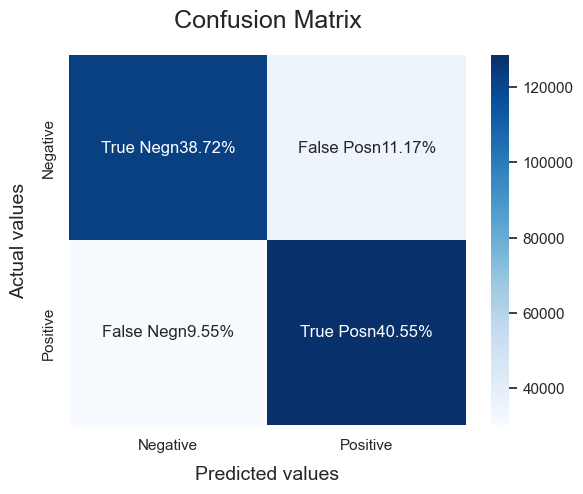

In [44]:
model_Evaluate(LogisticRegression_pipeline)

# 🔟 Model Deployment

In [45]:
import pickle

In [46]:
with open('Sentiment_Analysis_model.pkl', 'wb') as f:
    pickle.dump((LogisticRegression_pipeline,Preprocessing), f)

In [47]:
test_cases = pd.Series([
    "I absolutely loved the movie, it was fantastic!",
    "The customer service was terrible, I had a very bad experience.",
    "The weather today is amazing, perfect for a picnic!",
    "I'm feeling really happy and excited about the upcoming event.",
    "The food at that restaurant was delicious, I highly recommend it.",
    "I can't believe how rude that person was to me, it ruined my day.",
    "This product exceeded all my expectations.",
    "I'm so disappointed with the quality of this product, it's not worth the money.",
    "The performance of the new software update is incredibly fast and efficient.",
    "The traffic this morning was horrendous, I was stuck for hours."
])

labels = pd.Series([
    "Positive",
    "Negative",
    "Positive",
    "Positive",
    "Positive",
    "Negative",
    "Positive",
    "Negative",
    "Positive",
    "Negative"
])



In [48]:
LogisticRegression_pipeline.predict(test_cases)

array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [49]:
tweet_test_cases = pd.Series([
    "Just watched the latest episode of my favorite TV show! It was amazing! ",
    "Feeling so tired today, need a nap ASAP 😴 ",
    "This new restaurant in town is fantastic! The food is delicious and the service is excellent.",
    "Stuck in traffic again! This commute is the worst part of my day. ",
    "Spending the day at the beach with friends. Couldn't ask for a better way to relax! ",
    "The customer service at this store is terrible. I've been waiting in line for ages! ",
    "Just got a promotion at work! Hardwork pays off. ",
    "Feeling overwhelmed with all the work I have to do. ",
    "Attending my best friend's wedding today! So happy for them!",
    "Got a flat tire on the way to work. This day couldn't get any worse! "
])


tweet_labels = [
    "Positive",
    "Negative",
    "Positive",
    "Negative",
    "Positive",
    "Negative",
    "Positive",
    "Negative",
    "Positive",
    "Negative"
]

In [50]:
LogisticRegression_pipeline.predict(tweet_test_cases)

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [51]:
# pickle.dump(LogisticRegression_pipeline,open('Sentiment_Analysis.pkl','wb'))
# with open('Sentiment_Analysis_model.pkl', 'rb') as f:
#     model,Preprocessing1 = pickle.load(f)
# model.predict(test_cases)